# Project 5c-SIR models

A classic epidemiological model is called the SIR model, which stands for Susceptible-Infected-Recovered (or more broadly Removed, if the disease is potentially fatal).  As the name implies, this is a population model with three populations.  The equations are pretty simple (even simpler than zombies):
$$
\frac{\partial S}{\partial t} = -\beta S I
$$
$$
\frac{\partial I}{\partial t} = \beta S I - \gamma I
$$
$$
\frac{\partial R}{\partial t} = \gamma I,
$$
yet they have rather successfully been used to model a broad array of epidemics, including, in a practical sense, COVID-19.  Implement the above equations and explore their behavior for a few combinations of parameters and initial conditions.  What are the stable states?  Does this model exhibit periodicity?

### Comparison to observations

While it is useful to examine the qualitative evolution of these systems, they are not necessarily useful for modelling real epidemics because it is not clear what the values of the parameters ought to be.  In order to do that, they need to be tuned so as to reproduce a set of real observations.  I have provided for you code to read in and process data from the first year of the pandemic in Montana.  


Text(0.5, 0, 'Days')

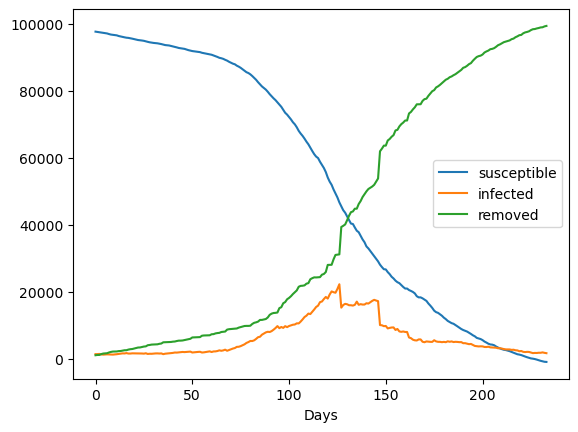

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('ef7e2f14.csv')

N = 1.0e5 # Initial susceptible population, here taken to be approximately 1/10 of the actual population of the state
          # or around the same amount of people that end up getting infected
removed = data['recovered'] + data['deaths']
infected = data['confirmed'] - removed
susceptible = N - infected - removed

removed = removed[removed.notnull()].to_numpy()[100:]
infected = infected[infected.notnull()].to_numpy()[100:]
susceptible = susceptible[susceptible.notnull()].to_numpy()[100:]
times = np.linspace(0,len(susceptible)-1,len(susceptible))


plt.plot(times,susceptible,label='susceptible')
plt.plot(times,infected,label='infected')
plt.plot(times,removed,label='removed')
plt.legend()
plt.xlabel('Days')

Try to find coefficients $\beta$ and $\gamma$ and initial conditions such that your model approximately matches this data.